In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)

np.set_printoptions(precision=2)

In [2]:
import pickle

file = open('../sessionFiles.pickle', 'rb')
allSessions = pickle.load(file)
file.close()

sessionDict = allSessions[0]
sessionDict.keys()

dict_keys(['subID', 'trialInfo', 'expConfig', 'rawExpUnity', 'rawExpGaze', 'processedExp', 'rawCalibUnity', 'rawCalibGaze', 'processedCalib', 'analysisParameters', 'fixAssessmentData'])

In [3]:
def runCalibrationAssessment(sessionDictIn):

    blockDistList = []
    accuracy_tr = []
    prec_tr = []
    pctDropouts_tr = []
    numDropouts_tr = []
    azErr_tr = []
    elErr_tr = []
    targLocAz_tr = []
    targLocEl_tr = []
    meanGazeAz_tr = []
    meanGazeEl_tr = []

    calibProc_gbBlock_Trial = sessionDictIn['processedCalib'].groupby(['blockNumber','trialNumber'])

    ############################################################
    ############################################################
    ## Iterate through assessment block

    trInfo_gbBlock = sessionDictIn['trialInfo'].groupby(['blockNumber'])
    # trInfo_gbBlock.get_group(1) # temp


    for idx, trInfoInBlock in trInfo_gbBlock:

    # trInfoInBlock = trialInfo_gbBlock.get_group(1)  # temp

        blNum = int(trInfoInBlock.iloc[0]['blockNumber'])

        if( np.unique(trInfoInBlock['trialType'])[0] != "CalibrationAssessment" ):

            # these are not calibration trials, so fill the lists with nans

            nanList_tr =  np.empty((1,len(trInfoInBlock)))[0]
            nanList_tr[:] = np.nan

            accuracy_tr.extend(nanList_tr)
            prec_tr.extend(nanList_tr)
            pctDropouts_tr.extend(nanList_tr)
            numDropouts_tr.extend(nanList_tr)
            azErr_tr.extend(nanList_tr)
            elErr_tr.extend(nanList_tr)
            targLocAz_tr.extend(nanList_tr)
            targLocEl_tr.extend(nanList_tr)
            meanGazeEl_tr.extend(nanList_tr)
            meanGazeAz_tr.extend(nanList_tr)

        else: 

            # calibTrData = gbCalib.get_group((int(assTrial['blockNumber']), int(assTrial['trialNumber'])))

            ## Check for assessment trials that were strangely far apart in time
            startTimes = trInfoInBlock['startTime']
            timeBetweenFixations = startTimes.diff().values

            if(any(timeBetweenFixations > sessionDict['analysisParameters']['warnIfAssessmentTrialsNSecondsApart'])):
                logger.warning('Note that assessment trials were spaced more than the duration threshold specified by sessionDict[\'analysisParameters\'][\'warnIfAssessmentTrialsNSecondsApart\'].')

            ############################################################
            ############################################################
            ## Iterate through each trial in the block
            for trIdx, thisTrInfo in trInfoInBlock.iterrows():

                trNum = thisTrInfo['trialNumber'].iloc[0]

                # Get rows of this trial from sessionDict['processedCalib']
                tr = calibProc_gbBlock_Trial.get_group((blNum, trNum))

                targetAz_fr = np.round( np.unique(tr['targetInHead_az']),2)
                targetEl_fr = np.round(np.unique(tr['targetInHead_el']),2)

                targLocAz_tr.extend(targetAz_fr)
                targLocEl_tr.extend(targetEl_fr)

                ## Check for multiple target locations within a single trial
                if ( len(np.unique(targetAz_fr)) > 1 or len(np.unique(targetAz_fr)) > 1 ):
                    logger.error('A single assessment trial has more than one target location.')

                # Robustness
                numDropouts = np.sum(tr.apply(lambda row: np.sum( row['gaze_normal2'].isnull()) > 0 ,axis=1)) - 1
                numDropouts_tr.append(numDropouts)

                # -1 because the first  frame is always nans
                pctDropouts = numDropouts  / len(tr)
                pctDropouts_tr.append(pctDropouts)

                # Mean gaze loc
                gazeAz_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['x'], tr['gaze_normal2']['z'] ))
                gazeEl_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['y'], tr['gaze_normal2']['z'] ))

                meanGazeAz_tr.append(np.nanmean(gazeAz_fr))
                meanGazeEl_tr.append(np.nanmean(gazeEl_fr))
                
                # Accuracy
                acc_fr = np.sqrt((gazeAz_fr - targetAz_fr)**2 + (gazeEl_fr - targetEl_fr)**2)
                accuracy_tr.append(np.nanmean(acc_fr))

                # Precision
                prec_fr = np.sqrt( (np.nanmean(gazeAz_fr) - gazeAz_fr)**2 + (np.nanmean(gazeEl_fr) - gazeEl_fr)**2)
                prec_tr.append(np.nanmean(prec_fr))

                # Err in Y and X direction
                azErr_tr.append(np.nanstd(gazeAz_fr))
                elErr_tr.append(np.nanstd(gazeEl_fr))

                ############################################################
                ## End trial loop

            blockAsessmentDict = {
                "blockNum": blNum,
                "meanAcc": np.nanmean(accuracy_tr),
                "minAcc": np.min(accuracy_tr),
                "maxAcc": np.max(accuracy_tr),
                "meanPrec": np.nanmean(prec_tr),
                "minPrec": np.min(prec_tr),
                "maxPrec": np.max(prec_tr),
                "totalDropouts": np.sum(numDropouts_tr),
                "totalNumFrames": len(sessionDictIn['processedCalib'].groupby(['blockNumber']).get_group(blNum)),
                "pctDropouts": np.nanmean(pctDropouts_tr),
                "gridWidthDegs": tr['azimuthWidth'].iloc[0],
                "gridHeightDegs": tr['elevationHeight'].iloc[0]


            }


            blockDistList.append(blockAsessmentDict)

            ############################################################
            ## End block loop


    assessmentDf = pd.DataFrame.from_records(blockDistList)
    sessionDictIn['calibrationQuality'] = assessmentDf

    sessionDictIn['trialInfo']['accuracy'] = accuracy_tr
    sessionDictIn['trialInfo']['precision'] = prec_tr
    sessionDictIn['trialInfo']['pctDropouts'] = pctDropouts_tr
    sessionDictIn['trialInfo']['numDropouts'] = numDropouts_tr
    sessionDictIn['trialInfo'][('assessmentErr','az')] = azErr_tr
    sessionDictIn['trialInfo'][('assessmentErr','el')] = elErr_tr
    sessionDictIn['trialInfo'][('targetSphericalPosInHead','az')] = targLocAz_tr
    sessionDictIn['trialInfo'][('targetSphericalPosInHead','el')] = targLocEl_tr
    sessionDictIn['trialInfo'][('gazeSphericalPosInHead','az')] = meanGazeAz_tr
    sessionDictIn['trialInfo'][('gazeSphericalPosInHead','el')] = meanGazeEl_tr


    return sessionDictIn

In [4]:
sessionDict = runCalibrationAssessment(sessionDict)

In [5]:
sessionDict['trialInfo'][('gazeSphericalPosInHead','el')].values

array([ 13.92,  14.41,  14.86,  -2.35,  -0.51,  -1.3 , -13.  , -11.27,
       -12.95,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
      

In [6]:
sessionDict['trialInfo'][('targetSphericalPosInHead','el')].values


array([ 15.,  15.,  15.,   0.,   0.,   0., -15., -15., -15.,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

<IPython.core.display.Javascript object>


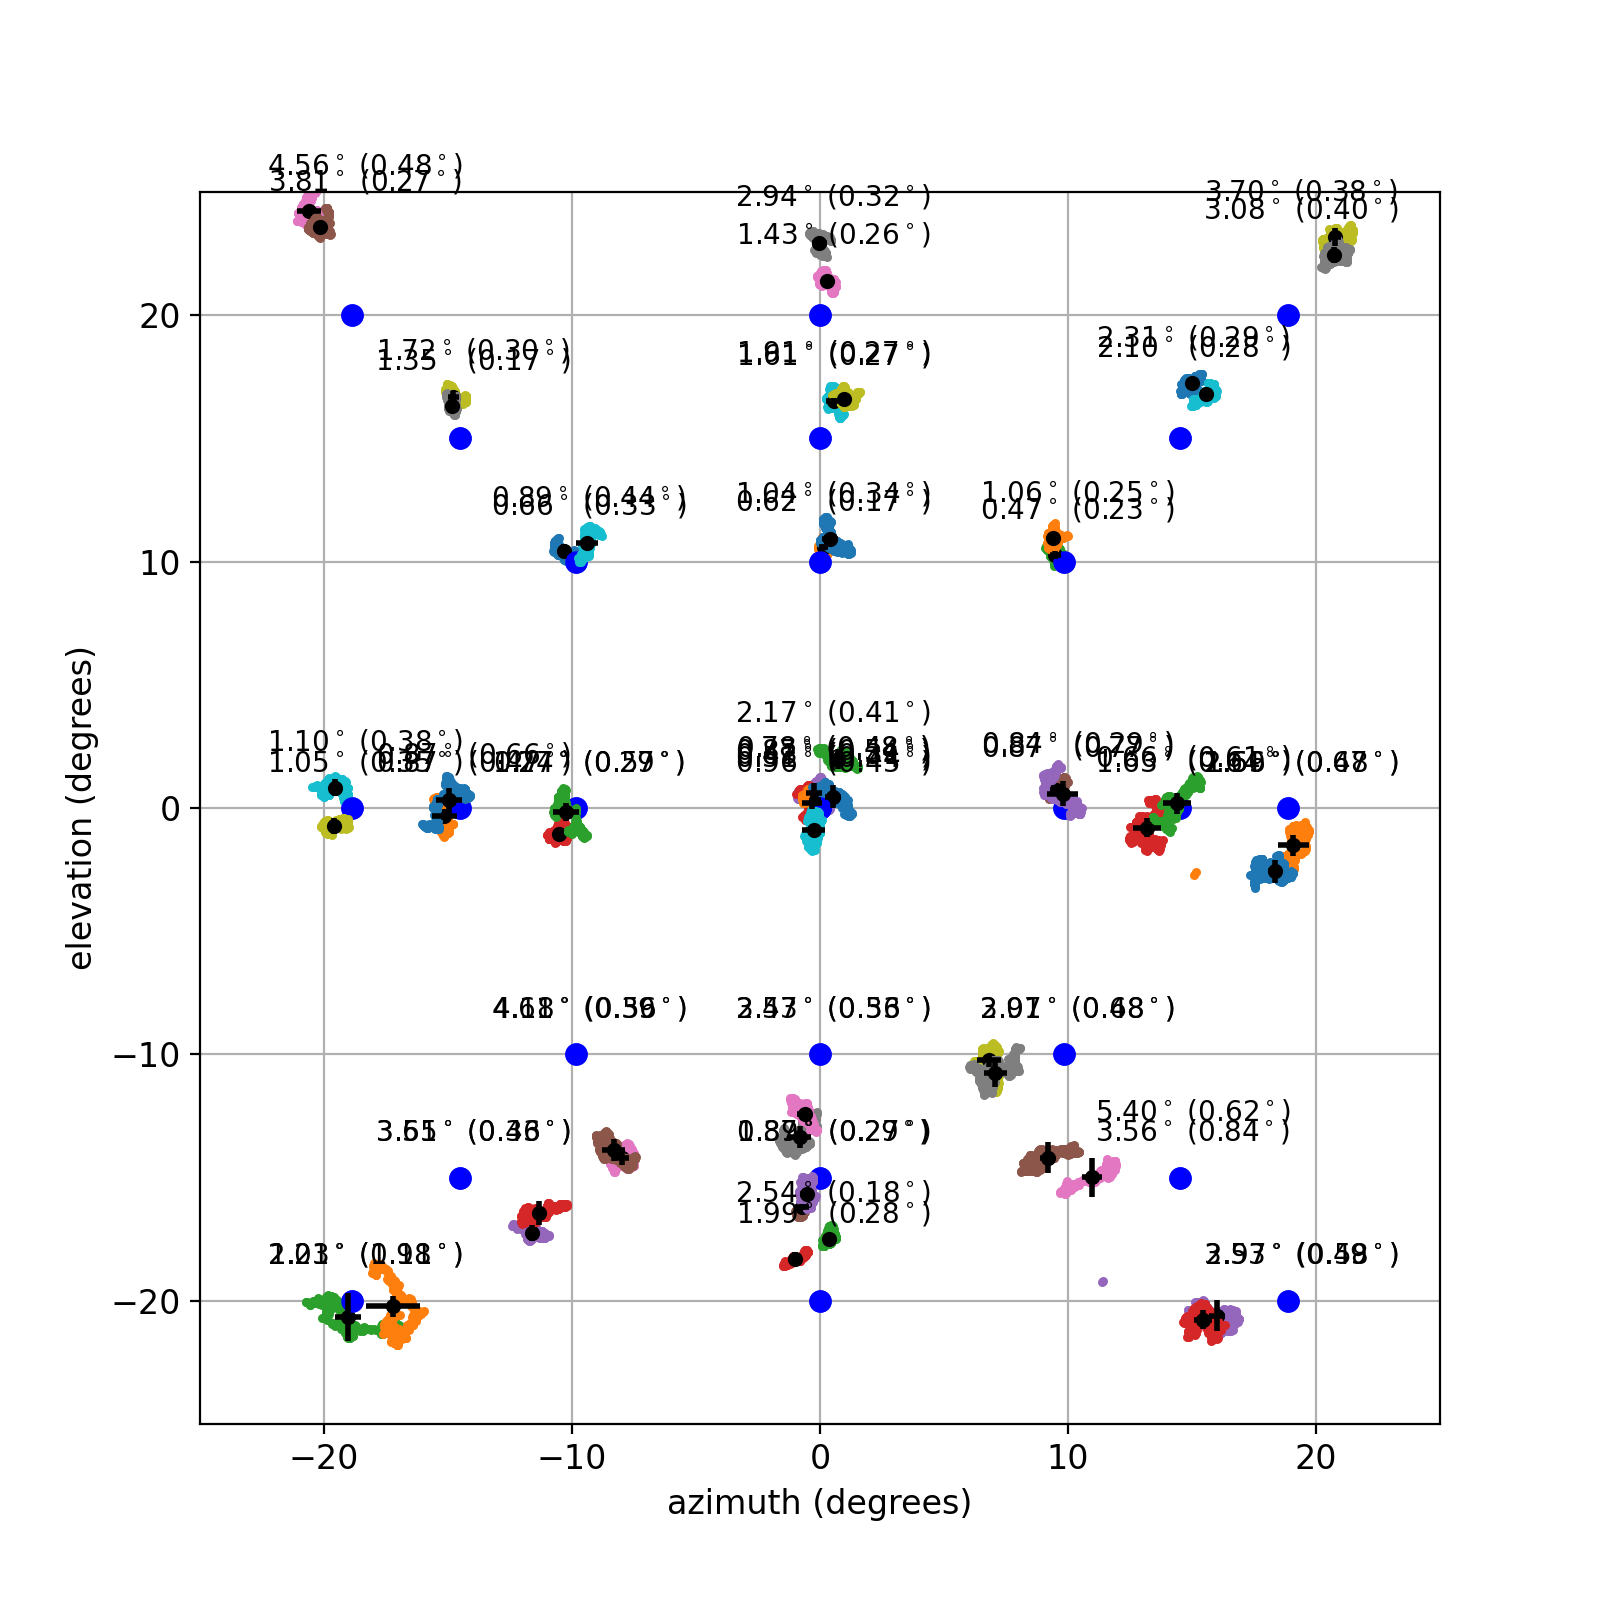

In [9]:
import copy
sessionDictIn = copy.deepcopy(sessionDict)

# def plotTrackQuality(sessionDictIn):

p, ax = plt.subplots(1, 1) #sharey=True)
p.set_size_inches(8,8)

cList = ['r','g','b']
lineHandles = []

offsets = np.linspace(-.01,.01,3)

calibProc_gbBlock_Trial = sessionDictIn['processedCalib'].groupby(['blockNumber','trialNumber'])
trInfo_gbBlock = sessionDictIn['trialInfo'].groupby(['blockNumber'])

# Iterate through blocks
# for idx, trInfoInBlock in trInfo_gbBlock:
trInfoInBlock = trInfo_gbBlock.get_group(1)

blNum = int(trInfoInBlock.iloc[0]['blockNumber'])

# Iterate through rows
if( np.unique(trInfoInBlock['trialType'])[0] == "CalibrationAssessment" ):

        for trIdx, thisTrInfo in trInfoInBlock.iterrows():

            trNum = thisTrInfo['trialNumber'].iloc[0]

            # Get rows of this trial from sessionDict['processedCalib']
            tr = calibProc_gbBlock_Trial.get_group((blNum, trNum))    

            # Targets
            xx = thisTrInfo[('targetSphericalPosInHead','az')]
            yy = thisTrInfo[('targetSphericalPosInHead','el')]
            hT = ax.scatter(xx, yy,s=50,c='b')
            hT.set_label('target')

            gazeAz_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['x'], tr['gaze_normal2']['z'] ))
            gazeEl_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['y'], tr['gaze_normal2']['z'] ))

            hT = ax.scatter(gazeAz_fr,gazeEl_fr,s=5)

            meanGazeAz = thisTrInfo[('gazeSphericalPosInHead','az')] 
            meanGazeEl = thisTrInfo[('gazeSphericalPosInHead','el')] 

            stdGazeAz = thisTrInfo[('assessmentErr','az')]
            stdGazeEl = thisTrInfo[('assessmentErr','el')]

            ax.errorbar(meanGazeAz, meanGazeEl, stdGazeAz, stdGazeEl,c='k',elinewidth=2)
            ax.scatter(meanGazeAz, meanGazeEl,s=20,c='k')

            vPos = np.max([meanGazeEl,yy])
            textStr = '   %1.2f$^\circ$ (%1.2f$^\circ$)'%(thisTrInfo['accuracy'],thisTrInfo['precision'])
            hErr = ax.text(xx,vPos+1.5, textStr,horizontalalignment='center',size=10)

        ax.set_ylabel('elevation (degrees)', fontsize=12)
        ax.set_xlabel('azimuth (degrees)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.set_ylim([-25,25])
        ax.set_xlim([-25,25])

        ax.axes.yaxis.grid(True)
        ax.axes.xaxis.grid(True)
        ax.axes.set_axisbelow(True)

        plt.rcParams["font.family"] = "sans-serif"
        p.set_facecolor('w')




<IPython.core.display.Javascript object>


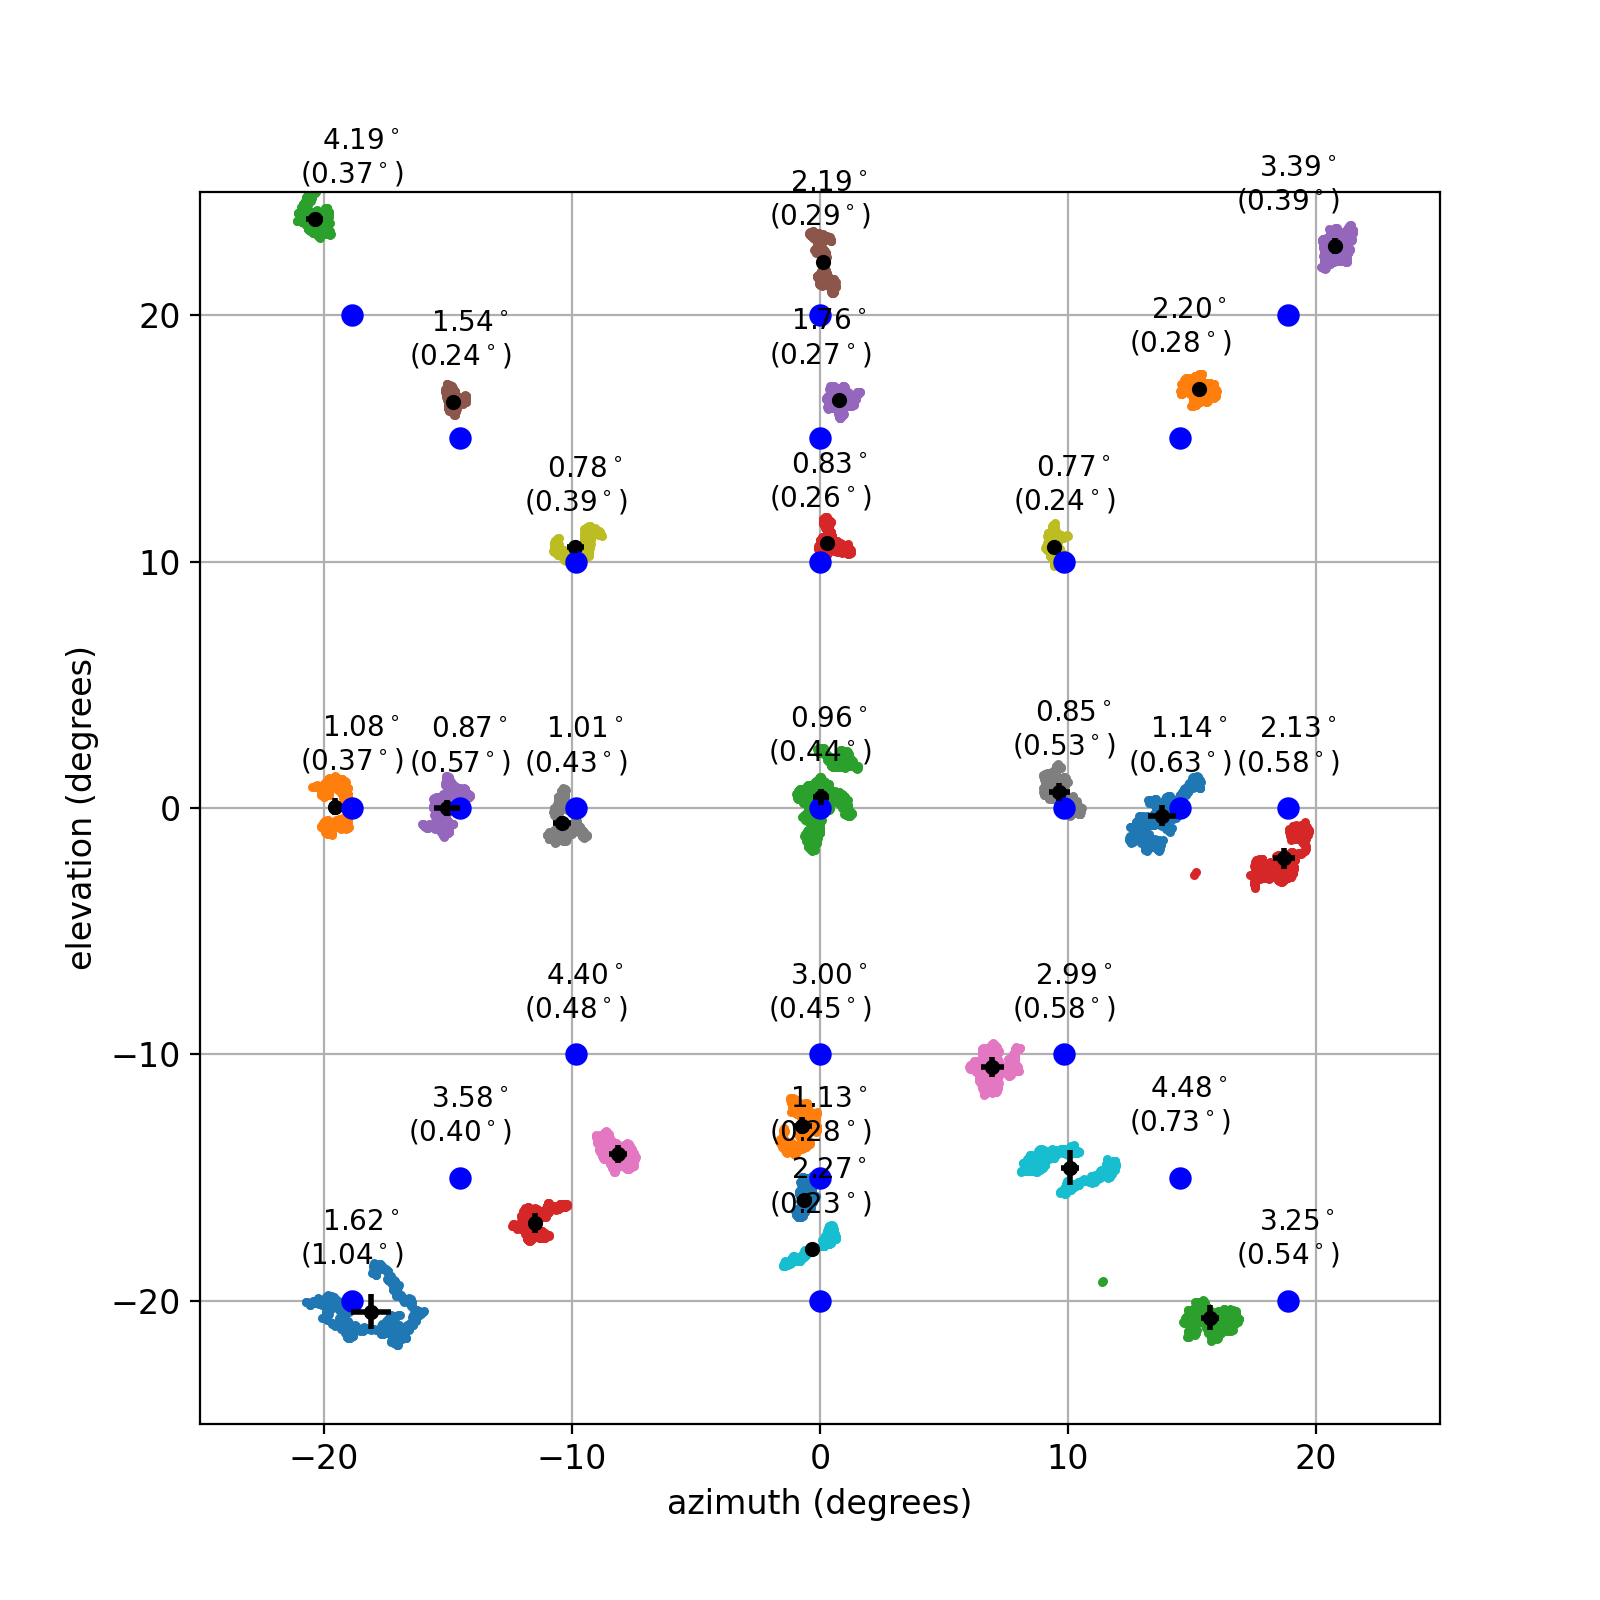

In [62]:
import copy
sessionDictIn = copy.deepcopy(sessionDict)

# def plotTrackQuality(sessionDictIn):

p, ax = plt.subplots(1, 1) #sharey=True)
p.set_size_inches(8,8)

cList = ['r','g','b']
lineHandles = []

offsets = np.linspace(-.01,.01,3)

calibProc_gbBlock_Trial = sessionDictIn['processedCalib'].groupby(['blockNumber','trialNumber'])
trInfo_gbBlock = sessionDictIn['trialInfo'].groupby(['blockNumber'])

# Iterate through blocks
# for idx, trInfoInBlock in trInfo_gbBlock:
trInfoInBlock = trInfo_gbBlock.get_group(1)

blNum = int(trInfoInBlock.iloc[0]['blockNumber'])

# if all trials are of type "CalibrationAssessment"...
if( np.unique(trInfoInBlock['trialType'])[0] == "CalibrationAssessment" ):

      

    for targIdx, thisTrInfo in gbTrialInfoByTargetPos_azEl:

# thisTrInfo = gbTrialInfoByTargetPos_azEl.get_group((18.88, 20.0))

        sessionDictIn['processedCalib'][('targetInHead_az', '')] = sessionDictIn['processedCalib'][('targetInHead_az', '')].round(2)
        sessionDictIn['processedCalib'][('targetInHead_el', '')] = sessionDictIn['processedCalib'][('targetInHead_el', '')].round(2)

        calibProc_gbTargAzEl = sessionDictIn['processedCalib'].groupby([('targetInHead_az', ''),('targetInHead_el', '')])

        trNum = thisTrInfo['trialNumber'].iloc[0]

        # Get rows of all calib trials with fix at this target
        tr = calibProc_gbTargAzEl.get_group((targIdx[0], targIdx[1]))



        gazeAz_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['x'], tr['gaze_normal2']['z'] ))
        gazeEl_fr = np.rad2deg(np.arctan2(tr['gaze_normal2']['y'], tr['gaze_normal2']['z'] ))

        hT = ax.scatter(gazeAz_fr,gazeEl_fr,s=5)

        meanGazeAz = thisTrInfo[('gazeSphericalPosInHead','az')].mean()
        meanGazeEl = thisTrInfo[('gazeSphericalPosInHead','el')].mean() 

        stdGazeAz = thisTrInfo[('assessmentErr','az')].mean()
        stdGazeEl = thisTrInfo[('assessmentErr','el')].mean()

        ax.errorbar(meanGazeAz, meanGazeEl, stdGazeAz, stdGazeEl,c='k',elinewidth=2)
        ax.scatter(meanGazeAz, meanGazeEl,s=20,c='k')
        
        # Targets
        xx = targIdx[0]
        yy = targIdx[1]
        hT = ax.scatter(xx, yy,s=50,c='b')
        hT.set_label('target')
        
        vPos = np.max([meanGazeEl,yy])
        textStr = '   %1.2f$^\circ$ \n(%1.2f$^\circ$)'%(thisTrInfo['accuracy'].mean(),thisTrInfo['precision'].mean())
        hErr = ax.text(xx,vPos+1.5, textStr,horizontalalignment='center',size=10)

        

        ax.set_ylabel('elevation (degrees)', fontsize=12)
        ax.set_xlabel('azimuth (degrees)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.set_ylim([-25,25])
        ax.set_xlim([-25,25])

        ax.axes.yaxis.grid(True)
        ax.axes.xaxis.grid(True)
        ax.axes.set_axisbelow(True)

        plt.rcParams["font.family"] = "sans-serif"
        p.set_facecolor('w')





In [63]:
gbTrialInfoByTargetPos_azEl = trInfoInBlock.groupby([('targetSphericalPosInHead','az'),('targetSphericalPosInHead','el')])
list(gbTrialInfoByTargetPos_azEl.groups.keys())

[(-18.88, -20.0),
 (-18.88, 0.0),
 (-18.88, 20.0),
 (-14.51, -15.0),
 (-14.51, 0.0),
 (-14.51, 15.0),
 (-9.85, -10.0),
 (-9.85, 0.0),
 (-9.85, 10.0),
 (0.0, -20.0),
 (0.0, -15.0),
 (0.0, -10.0),
 (0.0, 0.0),
 (0.0, 10.0),
 (0.0, 15.0),
 (0.0, 20.0),
 (9.85, -10.0),
 (9.85, 0.0),
 (9.85, 10.0),
 (14.51, -15.0),
 (14.51, 0.0),
 (14.51, 15.0),
 (18.88, -20.0),
 (18.88, 0.0),
 (18.88, 20.0)]